# Hoe kut zijn RE’s?

In [1]:
import plot
import utils
from datetime import datetime
import geoutils
import statistics

DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%S%z"

In [2]:
data = utils.read_json("data.json")

def line_with_station_info(line, station):
    for key in station["params"]:
        line[f"station_{key}"] = station["params"][key]
    return line


lines = [line_with_station_info(l, station) for station in data.values() for l in station["lines"]]
" | ".join(lines[0].keys())


'tripId | direction | line_name | line_id | admin | type | type_name | operator_name | operator_id | stops | station_key | station_station_id | station_name | station_region | station_country'

In [3]:
def calculate_diff_in_minutes(timestamp1, timestamp2):
    return (datetime.strptime(timestamp2, DATETIME_FORMAT) - datetime.strptime(timestamp1, DATETIME_FORMAT)).total_seconds() / 60

def calculate_diff_in_minutes_between_stops(st1, st2):
    departure = st1["departure"] if st1["departure"] != None else st1["arrival"]
    arrival = st2["arrival"] if st2["arrival"] != None else st2["departure"]
    return calculate_diff_in_minutes(departure, arrival)

for line in lines:
    def create_segment_object(s1, s2):
        time = calculate_diff_in_minutes_between_stops(s1, s2)
        dist = geoutils.distance(s1["location"], s2["location"]) * 1.1
        return {
            "time": time,
            "dist": dist,
            "speed": 60 * dist / time
        }

    line["segments"] = [create_segment_object(line["stops"][i - 1], s2) for (i, s2) in enumerate(line["stops"]) if i > 0]

    for stop in line["stops"]:
        arrival = stop["arrival"]
        departure = stop["departure"]

        if arrival != None and departure != None:
            stop["time"] = calculate_diff_in_minutes(arrival, departure)
        else: 
            stop["time"] = 0
    
    line["total_dist"] = sum([seg["dist"] for seg in line["segments"]])
    line["total_time"] = sum([st["time"] for st in line["stops"]]) + sum([seg["time"] for seg in line["segments"]])
    line["avg_speed"] = 60 * line["total_dist"] / line["total_time"] if line["total_time"] > 0 else 0
    line["median_time_between_stops"] = statistics.median([seg["time"] for seg in line["segments"]]) if len(line["segments"]) > 0 else 0

lines = [l for l in lines if l["total_time"] > 0]

In [4]:
german_lines = [l for l in lines if l["station_country"] == "D"]
dutch_lines = [l for l in lines if l["station_country"] == "NL"]

german_ice = [l for l in german_lines if l["type"] == "nationalExpress"] 
german_ic = [l for l in german_lines if l["type"] == "national"]
german_re = [l for l in german_lines if l["type_name"] == "RE"]
dutch_ic = [l for l in dutch_lines if l["type"] == "national"]
dutch_re = [l for l in dutch_lines if l["type"] == "regional"]

long_distance_lines = [l for l in lines if l["type"] in ["nationalExpress", "national"]]
regional_lines = [l for l in lines if l["type"] in ["regionalExp", "regional", "suburban"]]

In [5]:
station_names_dict = {}
for s in [st for l in lines for st in l["stops"]]:
    station_names_dict[s["id"]] = s["name"]

## Departures per station

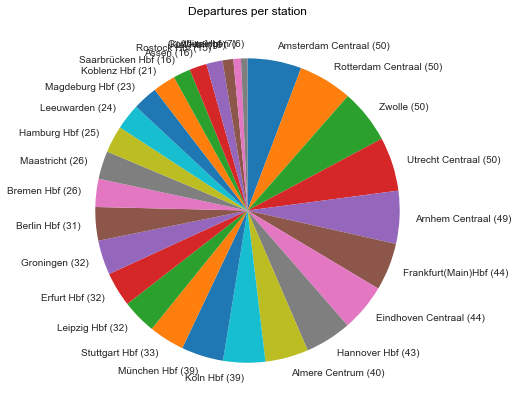

In [6]:
plot.pie(lines, "station_name", count_y=True, sort_by="y", display_absolute_value=True, title="Departures per station", save_to="img/deps_per_station")

## Travel time

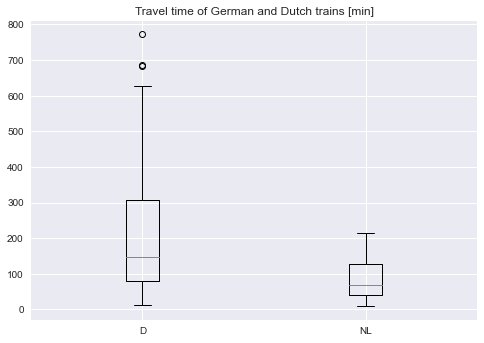

In [7]:
plot.box_plot([german_lines, dutch_lines], x="total_time", title="Travel time of German and Dutch trains [min]", x_tick_labels=["D", "NL"], save_to="img/time_dnl.png")

In [8]:
def print_top_ten(lines_arr, key, reverse=False):
    for (i, l) in enumerate(sorted(lines_arr, key=lambda l: l[key], reverse=reverse)[:10]):
        print(f"{i+1}: {l['line_name']}: {l['stops'][0]['name']}–{l['stops'][-1]['name']} ({l[key]})")

def print_german_and_dutch_top_ten(key, reverse=False):
    print(f"Top 10 German lines ({key}, reverse={reverse}):")
    print_top_ten(german_lines, key=key, reverse=reverse)
    print()

    print(f"Top 10 Dutch lines ({key}, reverse={reverse}):")
    print_top_ten(dutch_lines, key=key, reverse=reverse)

In [9]:
print_german_and_dutch_top_ten("total_time")

Top 10 German lines (total_time, reverse=False):
1: RB 76: Kiel Hbf–Kiel-Oppendorf (11.0)
2: S 5: Hannover Hbf–Hannover Flughafen (14.0)
3: RB 46: Cottbus Hbf–Forst(Lausitz) (18.0)
4: S 1: Rostock Hbf–Warnemünde (21.0)
5: RE 72: Kiel Hbf–Eckernförde (26.0)
6: HLB RB58: Frankfurt(Main)Hbf–Hanau Hbf (27.0)
7: RB 12: Rostock Hbf–Graal-Müritz (27.0)
8: S 4: Hannover Hbf–Bennemühlen (27.0)
9: S 5: Bietigheim-Bissingen–Stuttgart Schwabstr. (31.0)
10: RB 36: Magdeburg Hbf–Haldensleben (31.0)

Top 10 Dutch lines (total_time, reverse=False):
1: VIA RE19: Arnhem Centraal–Zevenaar (9.0)
2: 5382: Maastricht–Eijsden (10.0)
3: 5383: Maastricht–Eijsden (10.0)
4: RE 8529: Zwolle–Kampen(NL) (11.0)
5: RE 8531: Zwolle–Kampen(NL) (11.0)
6: RE 8533: Zwolle–Kampen(NL) (11.0)
7: RE 8535: Zwolle–Kampen(NL) (11.0)
8: RE 7532: Arnhem Centraal–Ede-Wageningen (15.0)
9: RE 7534: Arnhem Centraal–Ede-Wageningen (15.0)
10: RE 7536: Arnhem Centraal–Ede-Wageningen (15.0)


In [10]:
print_german_and_dutch_top_ten("total_time", reverse=True)

Top 10 German lines (total_time, reverse=True):
1: IC 2216: Offenburg–Greifswald (772.0)
2: IC 2217: Greifswald–Stuttgart Hbf (686.0)
3: ICE 618: München Hbf–Kiel Hbf (682.0)
4: ICE 1671: Ostseebad Binz–Karlsruhe Hbf (626.0)
5: ICE 1020: Regensburg Hbf–Hamburg-Altona (583.0)
6: ICE 1577: Stralsund Hbf–Karlsruhe Hbf (570.0)
7: IC 2212: Koblenz Hbf–Ostseebad Binz (563.0)
8: ICE 692: München Hbf–Berlin Ostbahnhof (550.0)
9: ICE 599: Berlin Ostbahnhof–München Hbf (548.0)
10: ICE 616: München Hbf–Hamburg-Altona (545.0)

Top 10 Dutch lines (total_time, reverse=True):
1: IC 3928: Heerlen–Enkhuizen (214.0)
2: IC 3930: Heerlen–Enkhuizen (214.0)
3: IC 3934: Heerlen–Enkhuizen (214.0)
4: IC 3936: Heerlen–Enkhuizen (214.0)
5: IC 3938: Heerlen–Enkhuizen (214.0)
6: IC 3940: Heerlen–Enkhuizen (214.0)
7: IC 3930: Heerlen–Enkhuizen (214.0)
8: IC 3935: Enkhuizen–Heerlen (212.0)
9: IC 3937: Enkhuizen–Heerlen (212.0)
10: IC 3929: Enkhuizen–Heerlen (212.0)


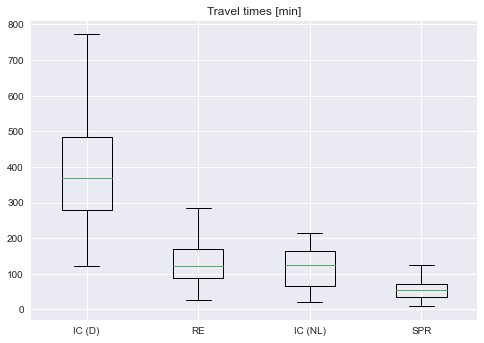

In [11]:
plot.box_plot([german_ic, german_re, dutch_ic, dutch_re], x="total_time", title="Travel times [min]", x_tick_labels=["IC (D)", "RE", "IC (NL)", "SPR"], save_to="img/time_categs.png")

### Median travel time between stops

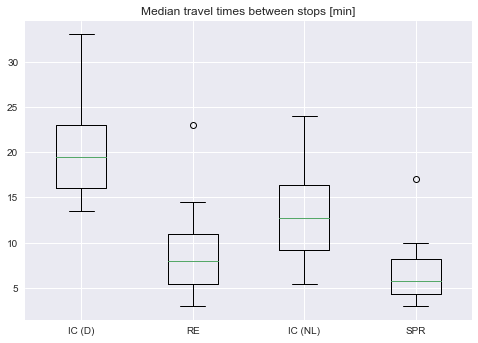

In [12]:
plot.box_plot([german_ic, german_re, dutch_ic, dutch_re], x="median_time_between_stops", title="Median travel times between stops [min]", x_tick_labels=["IC (D)", "RE", "IC (NL)", "SPR"], save_to="img/time_between_categs.png")

In [13]:
print_german_and_dutch_top_ten("median_time_between_stops")

Top 10 German lines (median_time_between_stops, reverse=False):
1: S 6: Frankfurt(Main)Süd–Groß Karben (1.0)
2: S 5: Frankfurt(Main)Süd–Friedrichsdorf(Taunus) (1.0)
3: S 4: München-Trudering–Buchenau(Oberbay) (1.0)
4: S 5: Friedrichsdorf(Taunus)–Frankfurt(Main)Süd (1.5)
5: S 6: Essen Hbf–Köln-Nippes (2.0)
6: S 11: Düsseldorf Flughafen Terminal–Bergisch Gladbach (2.0)
7: S 12: Hennef(Sieg)–Köln-Ehrenfeld (2.0)
8: S 12: Horrem–Hennef(Sieg) (2.0)
9: S 11: Bergisch Gladbach–Düsseldorf Flughafen Terminal (2.0)
10: S 6: Köln-Nippes–Essen Hbf (2.0)

Top 10 Dutch lines (median_time_between_stops, reverse=False):
1: RE 4037: Uitgeest–Rotterdam Centraal (3.0)
2: RE 4039: Uitgeest–Rotterdam Centraal (3.0)
3: RE 5128: Dordrecht–Den Haag Centraal (3.0)
4: RE 5028: Dordrecht–Den Haag Centraal (3.0)
5: RE 5130: Dordrecht–Den Haag Centraal (3.0)
6: RE 5030: Dordrecht–Den Haag Centraal (3.0)
7: RE 5132: Dordrecht–Den Haag Centraal (3.0)
8: 32026: Maastricht Randwyck–Heerlen (3.0)
9: 32025: Heerlen–Maas

In [14]:
print_german_and_dutch_top_ten("median_time_between_stops", reverse=True)

Top 10 German lines (median_time_between_stops, reverse=True):
1: Bus SEV: Kiel Hbf Kaistraße–Flensburg (85.0)
2: ICE 1006: München Hbf–Hamburg-Altona (45.0)
3: ICE 1008: München Hbf–Hamburg-Altona (44.5)
4: ICE 9556: Frankfurt(Main)Hbf–Saarbrücken Hbf (41.0)
5: TGV 9551: Saarbrücken Hbf–Frankfurt(Main)Hbf (40.0)
6: ICE 474: Basel Bad Bf–Hamburg Hbf (37.0)
7: ICE 93: Hamburg-Altona–Passau Hbf (34.0)
8: ICE 93: Hamburg-Altona–Passau Hbf (34.0)
9: ICE 535: Bremen Hbf–München Hbf (34.0)
10: ICE 585: Lübeck Hbf–München Hbf (34.0)

Top 10 Dutch lines (median_time_between_stops, reverse=True):
1: ICE 250: 's-Hertogenbosch–Amsterdam Centraal (27.5)
2: ICD 9223: Breda–Amsterdam Centraal (24.0)
3: ICD 926: Amsterdam Centraal–Breda (23.0)
4: ICD 9228: Amsterdam Centraal–Breda (23.0)
5: ICD 928: Amsterdam Centraal–Breda (23.0)
6: ICD 930: Amsterdam Centraal–Breda (23.0)
7: ICD 9224: Amsterdam Centraal–Breda (23.0)
8: ICD 917: Breda–Amsterdam Centraal (23.0)
9: ICD 924: Amsterdam Centraal–Breda (2

In [15]:
print_top_ten(german_re, "median_time_between_stops", reverse=True)

1: RE 87: Stuttgart Hbf–Singen(Hohentwiel) (23.0)
2: RE 17: Berlin Hbf (tief)–Elsterwerda (14.5)
3: RE 3: Erfurt Hbf–Jena-Göschwitz (13.0)
4: RE 17: Koblenz Hbf–Kaiserslautern Hbf (12.0)
5: RE 8: Hamburg Hbf–Lübeck Hbf (12.0)
6: RE 80: Hamburg Hbf–Lübeck Hbf (11.5)
7: RE 14: Frankfurt(Main)Hbf–Mannheim Hbf (11.0)
8: RE 8: Stuttgart Hbf–Würzburg Hbf (11.0)
9: RE 1: München Hbf–Ingolstadt Hbf (11.0)
10: RE 10: Cottbus Hbf–Leipzig Hbf (11.0)


## Distance

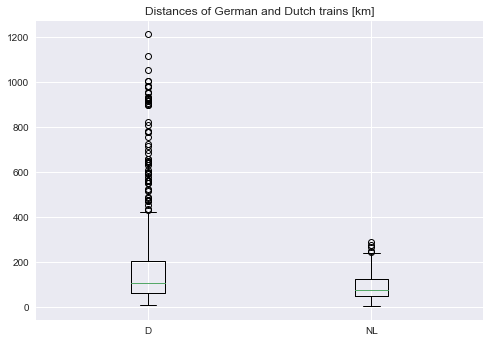

In [16]:
plot.box_plot([german_lines, dutch_lines], x="total_dist", title="Distances of German and Dutch trains [km]", x_tick_labels=["D", "NL"], save_to="img/dist_dnl.png")

In [17]:
print_german_and_dutch_top_ten("total_dist")

Top 10 German lines (total_dist, reverse=False):
1: RB 76: Kiel Hbf–Kiel-Oppendorf (6.407583661118373)
2: S 5: Hannover Hbf–Hannover Flughafen (11.972057293720242)
3: S 1: Rostock Hbf–Warnemünde (14.157289568602765)
4: S 1: Leipzig-Stötteritz–Leipzig Miltitzer Allee (22.10916517549659)
5: S 1: Leipzig Miltitzer Allee–Leipzig-Stötteritz (22.10916517549659)
6: S 4: Markkleeberg-Gaschwitz–Taucha(Leipzig) (22.65758978557418)
7: HLB RB58: Frankfurt(Main)Hbf–Hanau Hbf (23.524461302330852)
8: RB 46: Cottbus Hbf–Forst(Lausitz) (23.897062939360346)
9: HLB RB12: Frankfurt(Main)Hbf–Königstein(Taunus) (24.16534614589039)
10: RB 12: Rostock Hbf–Graal-Müritz (25.424638694437096)

Top 10 Dutch lines (total_dist, reverse=False):
1: RE 28305: Utrecht Centraal–Utrecht Maliebaan (1.6403711520191462)
2: 5382: Maastricht–Eijsden (9.801908240855745)
3: 5383: Maastricht–Eijsden (9.801908240855745)
4: RE 8529: Zwolle–Kampen(NL) (14.280422235768993)
5: RE 8531: Zwolle–Kampen(NL) (14.280422235768993)
6: RE 8533

In [18]:
print_german_and_dutch_top_ten("total_dist", reverse=True)

Top 10 German lines (total_dist, reverse=True):
1: IC 2216: Offenburg–Greifswald (1211.753907404297)
2: ICE 618: München Hbf–Kiel Hbf (1116.0104866518304)
3: IC 2217: Greifswald–Stuttgart Hbf (1053.1679411325722)
4: ICE 519: Hamburg-Altona–München Hbf (1003.6611483681284)
5: ICE 614: München Hbf–Hamburg-Altona (1003.6611483681282)
6: ICE 616: München Hbf–Hamburg-Altona (1003.6611483681282)
7: ICE 692: München Hbf–Berlin Ostbahnhof (981.1370765787772)
8: ICE 599: Berlin Ostbahnhof–München Hbf (981.137076578777)
9: ICE 598: München Hbf–Berlin Hbf (tief) (975.9012709099153)
10: ICE 1671: Ostseebad Binz–Karlsruhe Hbf (953.3029301905751)

Top 10 Dutch lines (total_dist, reverse=True):
1: IC 831: Schagen–Maastricht (285.8662481428388)
2: IC 3935: Enkhuizen–Heerlen (276.303914837685)
3: IC 3928: Heerlen–Enkhuizen (276.303914837685)
4: IC 3937: Enkhuizen–Heerlen (276.303914837685)
5: IC 3930: Heerlen–Enkhuizen (276.303914837685)
6: IC 3929: Enkhuizen–Heerlen (276.303914837685)
7: IC 3934: Heer

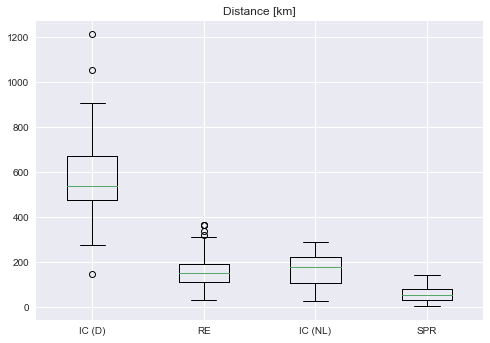

In [19]:
plot.box_plot([german_ic, german_re, dutch_ic, dutch_re], x="total_dist", title="Distance [km]", x_tick_labels=["IC (D)", "RE", "IC (NL)", "SPR"], save_to="img/dist_categs.png")

## Speed

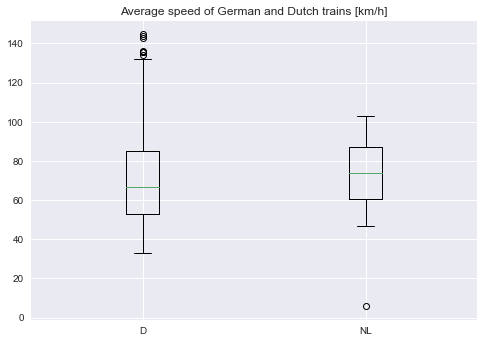

In [20]:
plot.box_plot([german_lines, dutch_lines], x="avg_speed", title="Average speed of German and Dutch trains [km/h]", x_tick_labels=["D", "NL"], save_to="img/speed_dnl.png")

In [21]:
print_german_and_dutch_top_ten("avg_speed")

Top 10 German lines (avg_speed, reverse=False):
1: S 1: Hamburg Airport–Hamburg-Blankenese (33.02060894578249)
2: S 1: Leipzig Miltitzer Allee–Leipzig-Stötteritz (33.163747763244885)
3: S 1: Leipzig-Stötteritz–Leipzig Miltitzer Allee (34.014100269994756)
4: S 5: Berlin Westkreuz–Berlin-Mahlsdorf (S) (34.13504306065811)
5: S 1: Wedel(Holst)–Hamburg Airport (34.77056393947703)
6: S 1: Hamburg Airport–Wedel(Holst) (34.770563939477036)
7: S 5: Berlin-Mahlsdorf (S)–Berlin Westkreuz (34.877109214150686)
8: RB 76: Kiel Hbf–Kiel-Oppendorf (34.95045633337295)
9: S 1: Wedel(Holst)–Hamburg-Poppenbüttel (34.9536233918693)
10: S 9: Flughafen BER - Terminal 1-2 (S-Bahn)–Berlin-Spandau (S) (38.53499689375833)

Top 10 Dutch lines (avg_speed, reverse=False):
1: RE 28305: Utrecht Centraal–Utrecht Maliebaan (5.789545242420516)
2: 32025: Heerlen–Maastricht Randwyck (46.59148027233017)
3: 32027: Heerlen–Maastricht Randwyck (46.59148027233017)
4: 32029: Heerlen–Maastricht Randwyck (46.59148027233017)
5: 320

In [22]:
print_german_and_dutch_top_ten("avg_speed", reverse=True)

Top 10 German lines (avg_speed, reverse=True):
1: ICE 1008: München Hbf–Hamburg-Altona (144.59141720369314)
2: ICE 1005: Hamburg-Altona–München Hbf (143.88508150158933)
3: ICE 1006: München Hbf–Hamburg-Altona (142.67375915059375)
4: ICE 602: München Hbf–Hamburg-Altona (136.1974585009146)
5: ICE 505: Hamburg-Altona–München Hbf (135.86033607888263)
6: ICE 1600: München Hbf–Hamburg-Altona (135.66930688342362)
7: ICE 507: Hamburg-Altona–München Hbf (135.52487845893475)
8: ICE 509: Hamburg-Altona–München Hbf (135.52487845893475)
9: ICE 703: Hamburg-Altona–München Hbf (134.15502393543562)
10: ICE 1010: Stuttgart Hbf–Dortmund Hbf (132.1182087835306)

Top 10 Dutch lines (avg_speed, reverse=True):
1: 37327: Groningen–Leeuwarden (102.78225716482208)
2: 37331: Groningen–Leeuwarden (102.78225716482208)
3: 37338: Leeuwarden–Groningen (102.78225716482208)
4: 37342: Leeuwarden–Groningen (102.78225716482208)
5: 37329: Groningen–Leeuwarden (102.57127017215218)
6: 37333: Groningen–Leeuwarden (102.571270

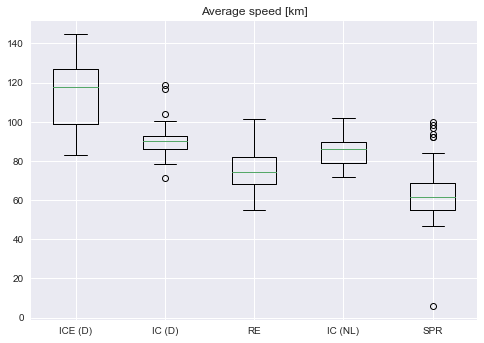

In [23]:
plot.box_plot([german_ice, german_ic, german_re, dutch_ic, dutch_re], x="avg_speed", title="Average speed [km]", x_tick_labels=["ICE (D)", "IC (D)", "RE", "IC (NL)", "SPR"], save_to="img/speed_categs.png")

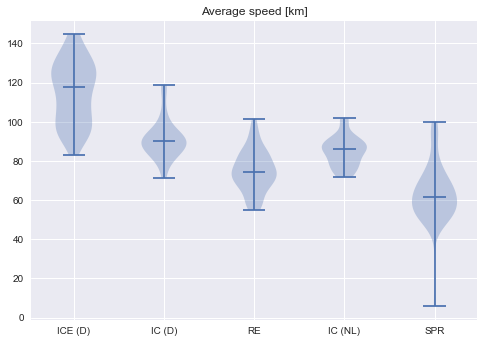

In [24]:
plot.box_plot([german_ice, german_ic, german_re, dutch_ic, dutch_re], x="avg_speed", title="Average speed [km]", x_tick_labels=["ICE (D)", "IC (D)", "RE", "IC (NL)", "SPR"], as_violin=True, save_to="img/speed_categs_violin.png")

In [25]:
print_top_ten(german_ic, "avg_speed", reverse=True)

1: IC 141: Bad Bentheim–Berlin Gesundbrunnen (118.6226394972697)
2: IC 148: Berlin Gesundbrunnen–Bad Bentheim (116.67800606288822)
3: IC 2408: Köln Hbf–Lübeck Hbf (104.02508443666667)
4: EC 9: Hamburg-Altona–Basel Bad Bf (100.44379597749071)
5: IC 2216: Offenburg–Greifswald (94.17776482416816)
6: IC 2443: Köln Hbf–Leipzig Hbf (92.98472660768302)
7: IC 2443: Köln Hbf–Leipzig Hbf (92.98472660768302)
8: EC 217: Saarbrücken Hbf–Freilassing (92.45653409428328)
9: IC 2005: Emden Hbf–Koblenz Hbf (92.43798338011808)
10: IC 2217: Greifswald–Stuttgart Hbf (92.11381409322789)


In [26]:
print_top_ten(german_re, "avg_speed", reverse=True)

1: RE 1: München Hbf–Ingolstadt Hbf (101.523569075345)
2: RE 20: Magdeburg Hbf–Uelzen (100.55596422317839)
3: RE 2: Cottbus Hbf–Berlin-Lichtenberg (99.52247862225553)
4: RE 70: Hamburg Hbf–Kiel Hbf (94.43724067948386)
5: RE 70: Kiel Hbf–Hamburg Hbf (94.43724067948385)
6: RE 9: Bremen Hbf–Osnabrück Hbf (93.2884384309079)
7: RE 10: Leipzig Hbf–Cottbus Hbf (92.71726539048547)
8: RE 7: Kiel Hbf–Hamburg Hbf (92.42610528594317)
9: RE 10: Cottbus Hbf–Leipzig Hbf (91.82575322326923)
10: RE 9: Osnabrück Hbf–Bremerhaven-Lehe (87.90326174851222)


## Long distance vs. regional

In [27]:
def conn_key(st1, st2):
    return (st1["id"], st2["id"])

parallel_connections = {}

for l in long_distance_lines:
    stops = l["stops"]
    for (i, st1) in enumerate(stops):
        for st2 in stops[i+1:]:
            key = conn_key(st1, st2)
            time = calculate_diff_in_minutes_between_stops(st1, st2)

            if key not in parallel_connections or parallel_connections[key]["ld"] > time:
                parallel_connections[key] = {"ld": time, "country": l["station_country"]}

for l in regional_lines:
    stops = l["stops"]
    for (i, st1) in enumerate(stops):
        for st2 in stops[i+1:]:
            key = conn_key(st1, st2)
            time = calculate_diff_in_minutes_between_stops(st1, st2)

            if key in parallel_connections and ("regio" not in parallel_connections[key] or parallel_connections[key]["regio"] > time):
                parallel_connections[key]["regio"] = time


regio_vs_long_distance = [{
    "from": station_names_dict[pair[0]],
    "to": station_names_dict[pair[1]],
    "ld": times["ld"],
    "regio": times["regio"],
    "ratio": times["regio"] / times["ld"],
    "country": times["country"]
} for pair, times in parallel_connections.items() if "regio" in times]

regio_vs_long_distance = sorted(regio_vs_long_distance, key=lambda o: o["ratio"], reverse=True)
regio_vs_long_distance_germany = [el for el in regio_vs_long_distance if el["country"] == "D"]
regio_vs_long_distance_netherlands = [el for el in regio_vs_long_distance if el["country"] == "NL"]

In [38]:
def print_top_ten_connections(arr):
    for i, el in enumerate(arr[:10]):
        print(f'{i+1}. {el["from"]}–{el["to"]}: {el["regio"]} min instead of {el["ld"]} (factor {el["ratio"]})')

In [39]:
print_top_ten_connections(regio_vs_long_distance_germany)

1. Erfurt Hbf–Halle(Saale)Hbf: 79.0 min instead of 27.0 (factor 2.925925925925926)
2. Mannheim Hbf–Koblenz Hbf: 257.0 min instead of 92.0 (factor 2.7934782608695654)
3. Erfurt Hbf–Leipzig Hbf: 117.0 min instead of 42.0 (factor 2.7857142857142856)
4. Koblenz Hbf–Mannheim Hbf: 254.0 min instead of 92.0 (factor 2.760869565217391)
5. Leipzig Hbf–Erfurt Hbf: 107.0 min instead of 40.0 (factor 2.675)
6. Heidelberg Hbf–Koblenz Hbf: 279.0 min instead of 106.0 (factor 2.6320754716981134)
7. Leipzig Hbf–Bamberg: 206.0 min instead of 86.0 (factor 2.395348837209302)
8. Eisenach–Leipzig Hbf: 165.0 min instead of 69.0 (factor 2.391304347826087)
9. Leipzig Hbf–Eisenach: 152.0 min instead of 66.0 (factor 2.303030303030303)
10. Gotha–Leipzig Hbf: 142.0 min instead of 62.0 (factor 2.2903225806451615)


In [40]:
print_top_ten_connections(regio_vs_long_distance_netherlands)

1. Amsterdam Sloterdijk–Hoorn: 83.0 min instead of 27.0 (factor 3.074074074074074)
2. Amsterdam Centraal–Hoorn: 88.0 min instead of 33.0 (factor 2.6666666666666665)
3. Utrecht Centraal–Amsterdam Zuid: 58.0 min instead of 22.0 (factor 2.6363636363636362)
4. Amsterdam Sloterdijk–Castricum: 44.0 min instead of 19.0 (factor 2.3157894736842106)
5. Utrecht Centraal–Schiphol (Airport): 65.0 min instead of 29.0 (factor 2.2413793103448274)
6. Amsterdam Zuid–Almere Centrum: 39.0 min instead of 19.0 (factor 2.0526315789473686)
7. Amsterdam Sloterdijk–Heiloo: 50.0 min instead of 25.0 (factor 2.0)
8. Almere Centrum–Amsterdam Zuid: 38.0 min instead of 19.0 (factor 2.0)
9. Duivendrecht–Almere Centrum: 32.0 min instead of 16.0 (factor 2.0)
10. Rotterdam Centraal–Amsterdam Centraal: 77.0 min instead of 39.0 (factor 1.9743589743589745)


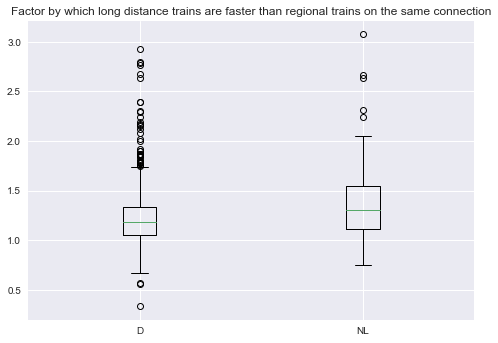

In [31]:
plot.box_plot([regio_vs_long_distance_germany, regio_vs_long_distance_netherlands], x_tick_labels=["D", "NL"], x="ratio", title="Factor by which long distance trains are faster than regional trains on the same connection", save_to="img/regio_vs_long_distance.png")

## Data per station

In [44]:
def boxplot_data_per_station(attribute, title):
    sorted_data = sorted(data.values(), key=lambda el: statistics.median([l[attribute] for l in el["lines"]]), reverse=True)
    lines_of_stations = [s["lines"] for s in sorted_data]
    station_names = [s["params"]["name"] for s in sorted_data]

    plot.box_plot(lines_of_stations, x=attribute, title=title, save_to=f"img/per_station_{attribute}.png")
    print("  ".join([f"{i+1}={n}" for i, n in enumerate(station_names)]))

1=Hannover Hbf  2=Assen  3=Zwolle  4=Leeuwarden  5=Bremen Hbf  6=Rotterdam Centraal  7=Utrecht Centraal  8=Vlissingen  9=Eindhoven Centraal  10=Berlin Hbf  11=Erfurt Hbf  12=Arnhem Centraal  13=Amsterdam Centraal  14=Cottbus Hbf  15=Almere Centrum  16=Groningen  17=Magdeburg Hbf  18=Leipzig Hbf  19=Hamburg Hbf  20=Saarbrücken Hbf  21=Koblenz Hbf  22=Köln Hbf  23=Maastricht  24=Kiel Hbf  25=München Hbf  26=Rostock Hbf  27=Stuttgart Hbf  28=Frankfurt(Main)Hbf


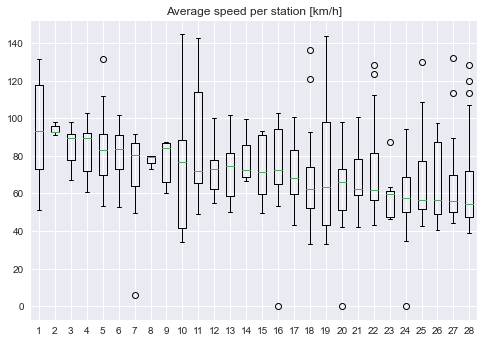

In [45]:
boxplot_data_per_station("avg_speed", "Average speed per station [km/h]")

1=Hannover Hbf  2=Vlissingen  3=Bremen Hbf  4=Eindhoven Centraal  5=Erfurt Hbf  6=Assen  7=Berlin Hbf  8=Koblenz Hbf  9=Leipzig Hbf  10=Arnhem Centraal  11=Cottbus Hbf  12=Köln Hbf  13=Saarbrücken Hbf  14=Magdeburg Hbf  15=Rotterdam Centraal  16=Amsterdam Centraal  17=Utrecht Centraal  18=Zwolle  19=Almere Centrum  20=Rostock Hbf  21=München Hbf  22=Kiel Hbf  23=Frankfurt(Main)Hbf  24=Hamburg Hbf  25=Stuttgart Hbf  26=Leeuwarden  27=Groningen  28=Maastricht


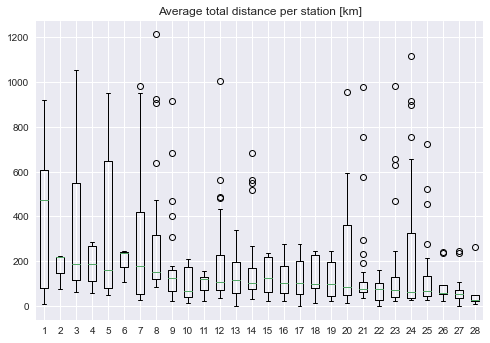

In [34]:
boxplot_data_per_station("total_dist", "Average total distance per station [km]")

1=Hannover Hbf  2=Vlissingen  3=Erfurt Hbf  4=Koblenz Hbf  5=Bremen Hbf  6=Eindhoven Centraal  7=Berlin Hbf  8=Köln Hbf  9=Rostock Hbf  10=Assen  11=Saarbrücken Hbf  12=Magdeburg Hbf  13=Leipzig Hbf  14=Utrecht Centraal  15=Amsterdam Centraal  16=Cottbus Hbf  17=Almere Centrum  18=Arnhem Centraal  19=München Hbf  20=Zwolle  21=Rotterdam Centraal  22=Frankfurt(Main)Hbf  23=Kiel Hbf  24=Stuttgart Hbf  25=Hamburg Hbf  26=Leeuwarden  27=Groningen  28=Maastricht


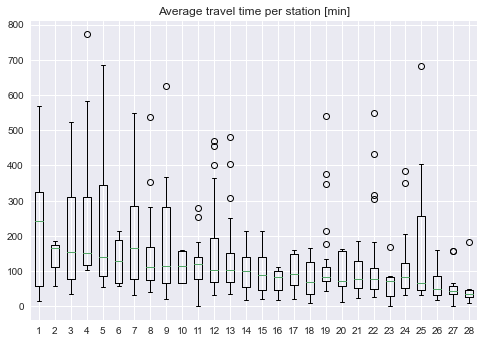

In [35]:
boxplot_data_per_station("total_time", "Average travel time per station [min]")